In [1]:
import allutils.graph_generator
from allutils.general_PR import flowPR
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import operator
import copy
import sys
import uuid
import pickle

In [2]:

#mode = sys.argv[1]
mode = 'facebook'

do_plot = True
do_dump = False

n = 100
iters = 100000
alpha = 0.85

beta = 0.0
gamma = 1.0

if mode != 'random':
    weights = 'real'
else:
    weights = 'random'

In [3]:

G = allutils.graph_generator.weighted_DiGraph(n, seed = 1.0, mode = mode, weights = weights)
norm = sum([val for (node, val) in G.out_degree(weight='weight')])
sampling_edges = {e[:-1]: e[-1]['weight']/norm for e in G.edges(data=True)}
personalization = {k: v / norm for k, v in G.out_degree(weight='weight')}
p_prime_nodes = {i: personalization[i]/G.out_degree(i, weight='weight') for i in G.nodes()}
pr = nx.pagerank(G, alpha=alpha, personalization=personalization, weight='weight')


344
DiGraph with 100 nodes and 3991 edges


In [4]:
rank_order = [key for (key, value) in sorted(pr.items(), key=operator.itemgetter(1), reverse=True)]
ordered_pr = np.array([pr[k] for k in rank_order])

RS, current = {},{}
array_tau, array_spearman, array_pearson, array_error = [],[],[],[]
rng = range(1, 101)


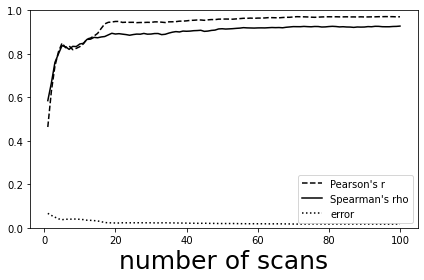

In [6]:

for i in rng:
    stream = [list(sampling_edges.keys())[i] for i in np.random.permutation(range(len(sampling_edges)))]
    
    RS, current, tau, spearman, pearson, error, x = flowPR(p_prime_nodes, pr, stream, copy.deepcopy(RS), copy.deepcopy(current), iters = iters, beta = beta, gamma = gamma)
    array_tau.append(copy.deepcopy(tau[-1]))
    array_spearman.append(copy.deepcopy(spearman[-1]))
    array_pearson.append(copy.deepcopy(pearson[-1]))
    array_error.append(copy.deepcopy(error[-1]))
    
if do_dump:
    unique_out = mode + '_one_run_' + str(uuid.uuid4())
    pickle.dump([array_pearson, array_spearman, array_tau, array_error, rng], open(unique_out + ".p", "wb"))

if do_plot:    
    plt.figure('one sweep '+ mode)        
    plt.plot(rng, array_pearson, 'k--')
    plt.plot(rng, array_spearman, 'k-')
    #plt.plot(rng, array_tau, 'k-.')
    plt.plot(rng, array_error, 'k:')

    plt.xlabel('number of scans', fontsize=25)
    plt.ylim((0, 1))
    plt.legend(['Pearson\'s r', 'Spearman\'s rho', 'error'], loc=0)
    plt.tight_layout()
    plt.savefig('one_sweep_'+ mode+'.pdf')
    